<a href="https://colab.research.google.com/github/FatmaBuseBorlu/Dramer-Dataset/blob/main/cnn_kodu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython import get_ipython
from IPython.display import display
import kagglehub
import shutil
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.signal import butter, lfilter

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, random_split
    from torcheeg.datasets import DREAMERDataset
    from torcheeg import transforms
except ModuleNotFoundError as e:
    raise ModuleNotFoundError(
        "PyTorch veya torcheeg kütüphanesi bulunamadı. Lütfen ortamınıza yükleyin veya alternatif bir yöntem kullanın."
    )

In [ ]:
# Kaggle'dan veri setini indirin
path = kagglehub.dataset_download("phhasian0710/dreamer")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/phhasian0710/dreamer/versions/1


In [ ]:
# Veri setini yükleyin ve ön işleme adımlarını uygulayın
dataset = DREAMERDataset(
    io_path='./dreamer_cnn_data',
    mat_path=f'{path}/DREAMER.mat',  # Kaggle'dan indirilen dosyanın yolu
    offline_transform=transforms.Compose([
        transforms.BaselineRemoval(),
        transforms.MeanStdNormalize(),
        transforms.To2d()
    ]),
    online_transform=transforms.ToTensor(),
    label_transform=transforms.Compose([
        transforms.Select('valence'),
        transforms.Binary(3.0)
    ]),
    chunk_size=128,
    baseline_chunk_size=128,
    num_baseline=61,
    num_worker=4
)

[2024-12-18 16:19:45] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ./dreamer_cnn_data.
INFO:torcheeg:🔍 | Detected cached processing results, reading cache from ./dreamer_cnn_data.


In [ ]:
# Veri setini eğitim ve test olarak ayırın
data_size = len(dataset)
train_size = int(0.8 * data_size)
test_size = data_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
# Veri yükleyicileri tanımlayın
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# İyileştirilmiş EEG tabanlı CNN modeli
class EEGCNN(nn.Module):
    def __init__(self):
        super(EEGCNN, self).__init__()
        # Veri boyutu: (batch, 1, kanal=14, zaman=128)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Ekstra konvolüyon katmanı
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.batch_norm1 = nn.BatchNorm2d(32)  # Batch normalization ekledik
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2048, 256)  # Sabit boyutlu fc1
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Modeli, kaybı ve optimizasyonu tanımlayın
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)  # CosineAnnealingLR ekleniyor

train_losses = []
test_losses = []
test_accuracies = []

def train_one_epoch():
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.float().to(device)
        labels = labels.long().to(device)
        if inputs.dim() == 3:
            inputs = inputs.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Yalnızca belli batch'lerde detaylı çıktı
        if batch_idx % 100 == 0:  # Her 100 batch'te bir yazdır
            print(f"Batch {batch_idx}, Loss: {loss.item():.4f}")
    return running_loss / len(train_loader)

def test_model():
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)
            if inputs.dim() == 3:
                inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_labels, all_preds

In [ ]:
class_weights = torch.tensor([2.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# Early Stopping Parametreleri
patience = 3  # İyileşme durduktan sonra kaç epoch daha devam edeceğini belirtir
best_loss = float('inf')  # İlk en iyi loss değeri
counter = 0  # Epoch sayacı

# Eğitim döngüsü
epochs = 10
for epoch in range(epochs):
    train_loss = train_one_epoch()
    test_loss, test_acc, _, _ = test_model()
    scheduler.step()  # Scheduler'i her epoch sonunda ekleyin

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Early Stopping Kontrolü
    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0  # Sayaç sıfırlanır
        print("Yeni en iyi model kaydedildi.")
    else:
        counter += 1
        print(f"Val Loss iyileşmedi. Sabit kalan epoch sayısı: {counter}")

    if counter >= patience:
        print("Early stopping tetiklendi!")
        break


Batch 0, Loss: 0.7011
Batch 100, Loss: 0.7055
Batch 200, Loss: 0.6731
Batch 300, Loss: 0.6625
Batch 400, Loss: 0.6498
Batch 500, Loss: 0.6943
Batch 600, Loss: 0.6434
Batch 700, Loss: 0.6672
Batch 800, Loss: 0.5946
Batch 900, Loss: 0.7367
Batch 1000, Loss: 0.6166
Batch 1100, Loss: 0.6431
Batch 1200, Loss: 0.6858
Batch 1300, Loss: 0.5694
Batch 1400, Loss: 0.6554
Batch 1500, Loss: 0.6741
Batch 1600, Loss: 0.5809
Batch 1700, Loss: 0.5631
Batch 1800, Loss: 0.5982
Batch 1900, Loss: 0.5636
Batch 2000, Loss: 0.5595
Batch 2100, Loss: 0.6978
Epoch [1/10] - Train Loss: 0.6355, Test Loss: 0.5967, Test Acc: 0.6484
Yeni en iyi model kaydedildi.
Batch 0, Loss: 0.5356
Batch 100, Loss: 0.7021
Batch 200, Loss: 0.6641
Batch 300, Loss: 0.5077
Batch 400, Loss: 0.4765
Batch 500, Loss: 0.6877
Batch 600, Loss: 0.5055
Batch 700, Loss: 0.5748
Batch 800, Loss: 0.8185
Batch 900, Loss: 0.5207
Batch 1000, Loss: 0.5828
Batch 1100, Loss: 0.4910
Batch 1200, Loss: 0.7214
Batch 1300, Loss: 0.6401
Batch 1400, Loss: 0.640

Final Test Accuracy: 0.7830
Confusion Matrix:
 [[5453 1331]
 [2391 7974]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.80      0.75      6784
           1       0.86      0.77      0.81     10365

    accuracy                           0.78     17149
   macro avg       0.78      0.79      0.78     17149
weighted avg       0.79      0.78      0.78     17149



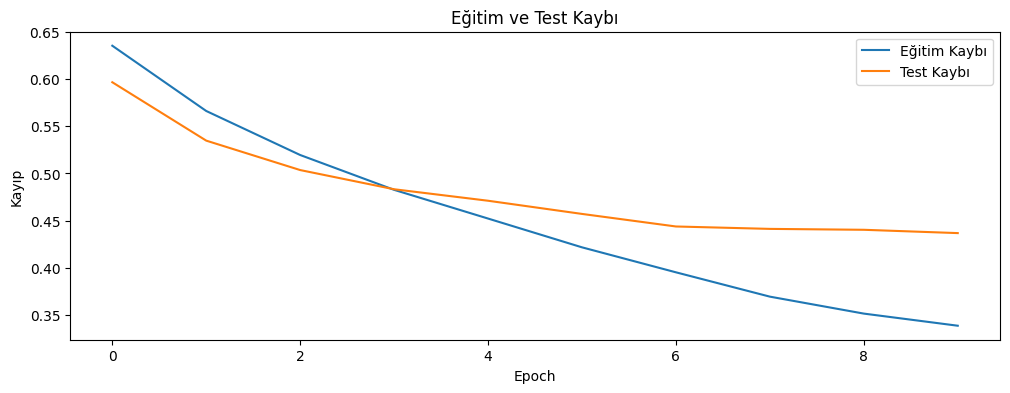

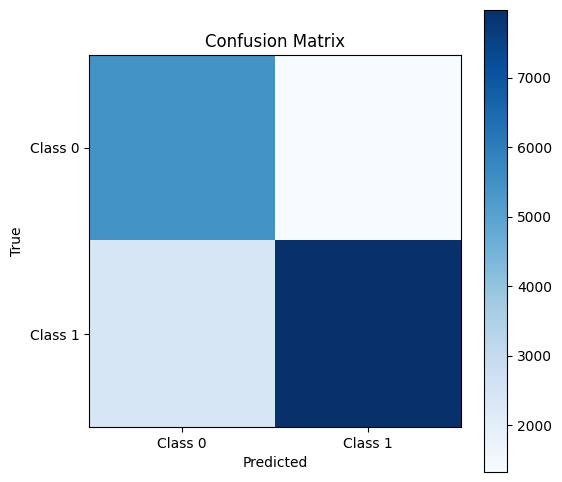

In [ ]:
# Sonuçları tekrar test edip raporla
test_loss, test_acc, all_labels, all_preds = test_model()
print(f"Final Test Accuracy: {test_acc:.4f}")
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(all_labels, all_preds))

def plot_results(labels, preds, train_losses, test_losses):
    # Basitleştirilmiş grafik fonksiyonu
    plt.figure(figsize=(12, 4))
    plt.plot(train_losses, label='Eğitim Kaybı')
    plt.plot(test_losses, label='Test Kaybı')
    plt.title('Eğitim ve Test Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 6))
    cm = confusion_matrix(labels, preds)
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1], ['Class 0', 'Class 1'])
    plt.yticks([0, 1], ['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_results(all_labels, all_preds, train_losses, test_losses)

In [ ]:
print(f"Toplam veri sayısı: {len(train_loader.dataset)}")
print(f"Toplam batch sayısı (train): {len(train_loader)}")

Toplam veri sayısı: 68595
Toplam batch sayısı (train): 2144
